In [1]:
import warnings
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning
)

In [2]:
import os

import FACSPy as fp
import scanpy as sc

import figure_config as cfg

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.gridspec import GridSpec

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase

In [4]:
cd8 = fp.read_dataset(cfg.data_input, "dataset_CD8T_preprocessed")
cd8.uns["metadata"].dataframe["group"] = cd8.uns["metadata"].dataframe["diag_main"]

fp.sync.synchronize_dataset(cd8)

Found modified subsets: ['metadata_columns']
	... synchronizing dataset to contain columns of the metadata object
... synchronizing dataframe: mfi_sample_ID_compensated
     ... synchronized frame mfi_sample_ID_compensated
... synchronizing dataframe: mfi_sample_ID_transformed
     ... synchronized frame mfi_sample_ID_transformed
... synchronizing dataframe: fop_sample_ID_compensated
     ... synchronized frame fop_sample_ID_compensated
... synchronizing dataframe: fop_sample_ID_transformed
     ... synchronized frame fop_sample_ID_transformed


C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:12: UserWarning: It was detected that the dataset was modified.Please make sure that the performed analyses are still valid. Note that if you removed whole samples, mfi/fop calculations will not be affected.
  warnings.warn(message, UserWarning)
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\synchronization\_synchronize.py:106: DataModificationWarning: 'It was detected that the dataset was modified.Please make sure that the performed analyses are still valid. Note that if you removed whole samples, mfi/fop calculations will not be affected.'
  warnings.warn('', DataModificationWarning)


In [5]:
fp.settings.default_gate = "CD8_T_cells"
fp.settings.default_layer = "transformed"
fp.tl.mfi(cd8, layer = "compensated")
fp.tl.pca_samplewise(cd8, n_components = 2)

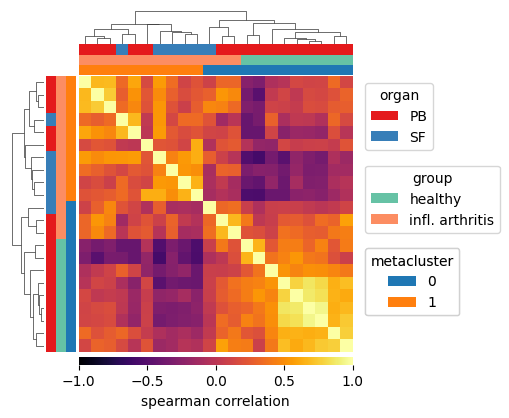

In [6]:
sns.reset_defaults()
corr_heatmap = fp.pl.sample_correlation(cd8,
                                        metadata_annotation = ["organ", "group"],
                                        metaclusters = 2,
                                        corr_method = "spearman",
                                        label_metaclusters_in_dataset = True,
                                        label_metaclusters_key = "sample_corr_metaclusters",
                                        return_fig = True,
                                        save = f"sample_correlation.png")
corr_heatmap.savefig('corr_heatmap.png', bbox_inches = "tight", dpi = 300, transparent = True)
plt.show()
plt.close(corr_heatmap.fig)


In [7]:
def generate_subfigure_a(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = -0.23)
    fig_sgs = gs.subgridspec(1,1)

    corr_heatmap = fig.add_subplot(fig_sgs[0])
    corr_heatmap.imshow(matplotlib.image.imread("corr_heatmap.png"))
    corr_heatmap.axis("off")

    return

In [8]:
def generate_subfigure_b(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = -0.15)
    fig_sgs = gs.subgridspec(3,2)

    diag_main = fig.add_subplot(fig_sgs[0:2,0])
    spca_organ_diag = fp.pl.pca_samplewise(
        cd8,
        color = "organ_diag",
        cmap = "Set1",
        show = False,
        ax = diag_main,
        edgecolor = "black"
    )
    diag_main.set_title("tissue and diagnosis", fontsize = cfg.TITLE_SIZE)
    handles, labels = diag_main.get_legend_handles_labels()
    diag_main.legend(handles,
                     ["healthy: PB",
                      "infl. arthr.: PB",
                      "infl. arthr.: SF"],
                     bbox_to_anchor = (0.5, -0.2),
                     loc = "upper center",
                     fontsize = cfg.AXIS_LABEL_SIZE)
    diag_main.set_xlabel(diag_main.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE, labelpad = 0)
    diag_main.set_ylabel(diag_main.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE, labelpad = 0)
    
    metaclusters = fig.add_subplot(fig_sgs[0:2,1])
    spca_mc = fp.pl.pca_samplewise(
        cd8,
        color = "sample_corr_metaclusters",
        cmap = "tab10",
        show = False,
        ax = metaclusters,
        edgecolor = "black"
    )
    
    metaclusters.set_title("Metaclusters", fontsize = cfg.TITLE_SIZE)
    handles, labels = metaclusters.get_legend_handles_labels()
    metaclusters.legend(handles, labels, bbox_to_anchor = (0.5, -0.2), loc = "upper center", fontsize = cfg.AXIS_LABEL_SIZE, ncol = 1)
    metaclusters.set_xlabel(metaclusters.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE, labelpad = 0)
    metaclusters.set_ylabel(metaclusters.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE, labelpad = 0)

    return

In [9]:
def generate_subfigure_c(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = -0.1)
    fig_sgs = gs.subgridspec(1,2)

    comp1 = fig.add_subplot(fig_sgs[0,0])
    #comp2 = fig.add_subplot(fig_sgs[0,1])
    comp3 = fig.add_subplot(fig_sgs[0,1])
    
    comp1 = fig.add_subplot(
        fp.pl.fold_change(cd8,
                          layer = "compensated",
                          groupby = "organ_diag",
                          group1 = "PB_healthy", 
                          group2 = "PB_infl. arthritis",
                          comparison_label = " ",
                          group1_label = "healthy: PB",
                          group2_label = "infl. arthritis: PB",
                          ax = comp1,
                          show = False)
    )
    
#    comp2 = fig.add_subplot(
#        fp.pl.fold_change(cd8,
#                          layer = "compensated",
#                          groupby = "organ_diag",
#                          group1 = "PB_healthy", 
#                          group2 = "SF_infl. arthritis",
#                          comparison_label = " ",
#                          group1_label = "healthy: PB",
#                          group2_label = "infl. arthritis: SF",
#                          ax = comp2,
#                          show = False
#        )
#    )
    
    comp3 = fig.add_subplot(
        fp.pl.fold_change(cd8,
                          layer = "compensated",
                          groupby = "organ_diag",
                          group1 = "PB_infl. arthritis", 
                          group2 = "SF_infl. arthritis",
                          comparison_label = " ",
                          group1_label = "infl. arthritis: PB",
                          group2_label = "infl. arthritis: SF",
                          ax = comp3,
                          show = False
        )
    )
    cfg._adjust_ylabels(comp1)
    comp1.set_xticklabels(comp1.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
    comp1.set_xlabel("asinh fold change", fontsize = cfg.AXIS_LABEL_SIZE)
    comp1.set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
    comp1.tick_params(size = cfg.AXIS_LABEL_SIZE, pad = 0, length = 0, which = "both")
    comp1.set_title(comp1.get_title(), fontsize = cfg.TITLE_SIZE)
    comp1._colorbars[0].set_yticklabels(comp1._colorbars[0].get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
    comp1._colorbars[0].set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
    
#    cfg._adjust_ylabels(comp2)
#    comp2.set_xticklabels(comp2.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
#    comp2.set_xlabel("asinh fold change", fontsize = cfg.AXIS_LABEL_SIZE)
#    comp2.set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
#    comp2.tick_params(size = cfg.AXIS_LABEL_SIZE, pad = 0, length = 0, which = "both")
#    comp2.set_title(comp2.get_title(), fontsize = cfg.TITLE_SIZE)
#    comp2._colorbars[0].set_yticklabels(comp2._colorbars[0].get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
#    comp2._colorbars[0].set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
    
    cfg._adjust_ylabels(comp3)
    comp3.set_xticklabels(comp3.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
    comp3.set_xlabel("asinh fold change", fontsize = cfg.AXIS_LABEL_SIZE)
    comp3.set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
    comp3.tick_params(size = cfg.AXIS_LABEL_SIZE, length = 0, which = "both")
    comp3.set_title(comp3.get_title(), fontsize = cfg.TITLE_SIZE)
    comp3._colorbars[0].set_yticklabels(comp3._colorbars[0].get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
    comp3._colorbars[0].set_ylabel("", fontsize = cfg.AXIS_LABEL_SIZE)
    return comp3

In [10]:
def generate_subfigure_d(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = -0.20)
    
    fig_sgs = gs.subgridspec(1,2)
    
    umap_organ_plot = fig.add_subplot(fig_sgs[0])
    umap_organ_plot = fp.pl.umap(
        cd8,
        color = "organ",
        show = False,
        ax = umap_organ_plot
    )
    umap_organ_plot.set_xlabel(umap_organ_plot.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    umap_organ_plot.set_ylabel(umap_organ_plot.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    umap_organ_plot.set_title("organ", fontsize = cfg.TITLE_SIZE)
    handles, labels = umap_organ_plot.get_legend_handles_labels()
    umap_organ_plot.legend(handles,
                           ["peripheral blood", "synovial fluid"],
                           bbox_to_anchor = (0.5, -0.1),
                           loc = "upper center",
                           fontsize = cfg.AXIS_LABEL_SIZE)

    umap_organ_diag_plot = fig.add_subplot(fig_sgs[1])
    umap_organ_diag_plot = fp.pl.umap(
        cd8,
        color = "organ_diag",
        show = False,
        ax = umap_organ_diag_plot
    )
    umap_organ_diag_plot.set_xlabel(umap_organ_diag_plot.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    umap_organ_diag_plot.set_ylabel(umap_organ_diag_plot.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    umap_organ_diag_plot.set_title("\n\norgan and group", fontsize = cfg.TITLE_SIZE)
    handles, labels = umap_organ_diag_plot.get_legend_handles_labels()
    umap_organ_diag_plot.legend(handles,
                                labels, #["peripheral blood", "synovial fluid"],
                                bbox_to_anchor = (0.5, -0.1),
                                loc = "upper center",
                                fontsize = cfg.AXIS_LABEL_SIZE)
    return

In [11]:
def generate_subfigure_e(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = -0.15)
    
    fig_sgs = gs.subgridspec(2,3)

    for i, marker in enumerate(["CD27", "CD69", "HLA_DR", "PD-1_(CD279) ", "TIGIT", "CD57"]):
        marker_plot = fig.add_subplot(fig_sgs[0 if i<=2 else 1, i%3])
        marker_plot = fp.pl.umap(
            cd8,
            color = marker,
            show = False,
            ax = marker_plot,
            vmin = 0
        )
        if marker == "PD-1_(CD279) ":
            marker = "PD-1"
        marker_plot.set_xlabel(marker_plot.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
        marker_plot.set_ylabel(marker_plot.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
        marker_plot.set_title(f"\n\n{marker}", fontsize = cfg.TITLE_SIZE)
        marker_plot._children[0].colorbar.ax.set_ylabel("")
        marker_plot._children[0].colorbar.ax.tick_params(labelsize = cfg.AXIS_LABEL_SIZE)
    return

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
C:\Users\tarik\AppData\Local\Temp\ipykernel_82804\496670702.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  comp1.set_xticklabels(comp1.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_82804\496670702.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  comp1._colorbars[0].set_yticklabels(comp1._colorbars[0].get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_82804\496670702.py:72: UserWarning: FixedFormatt

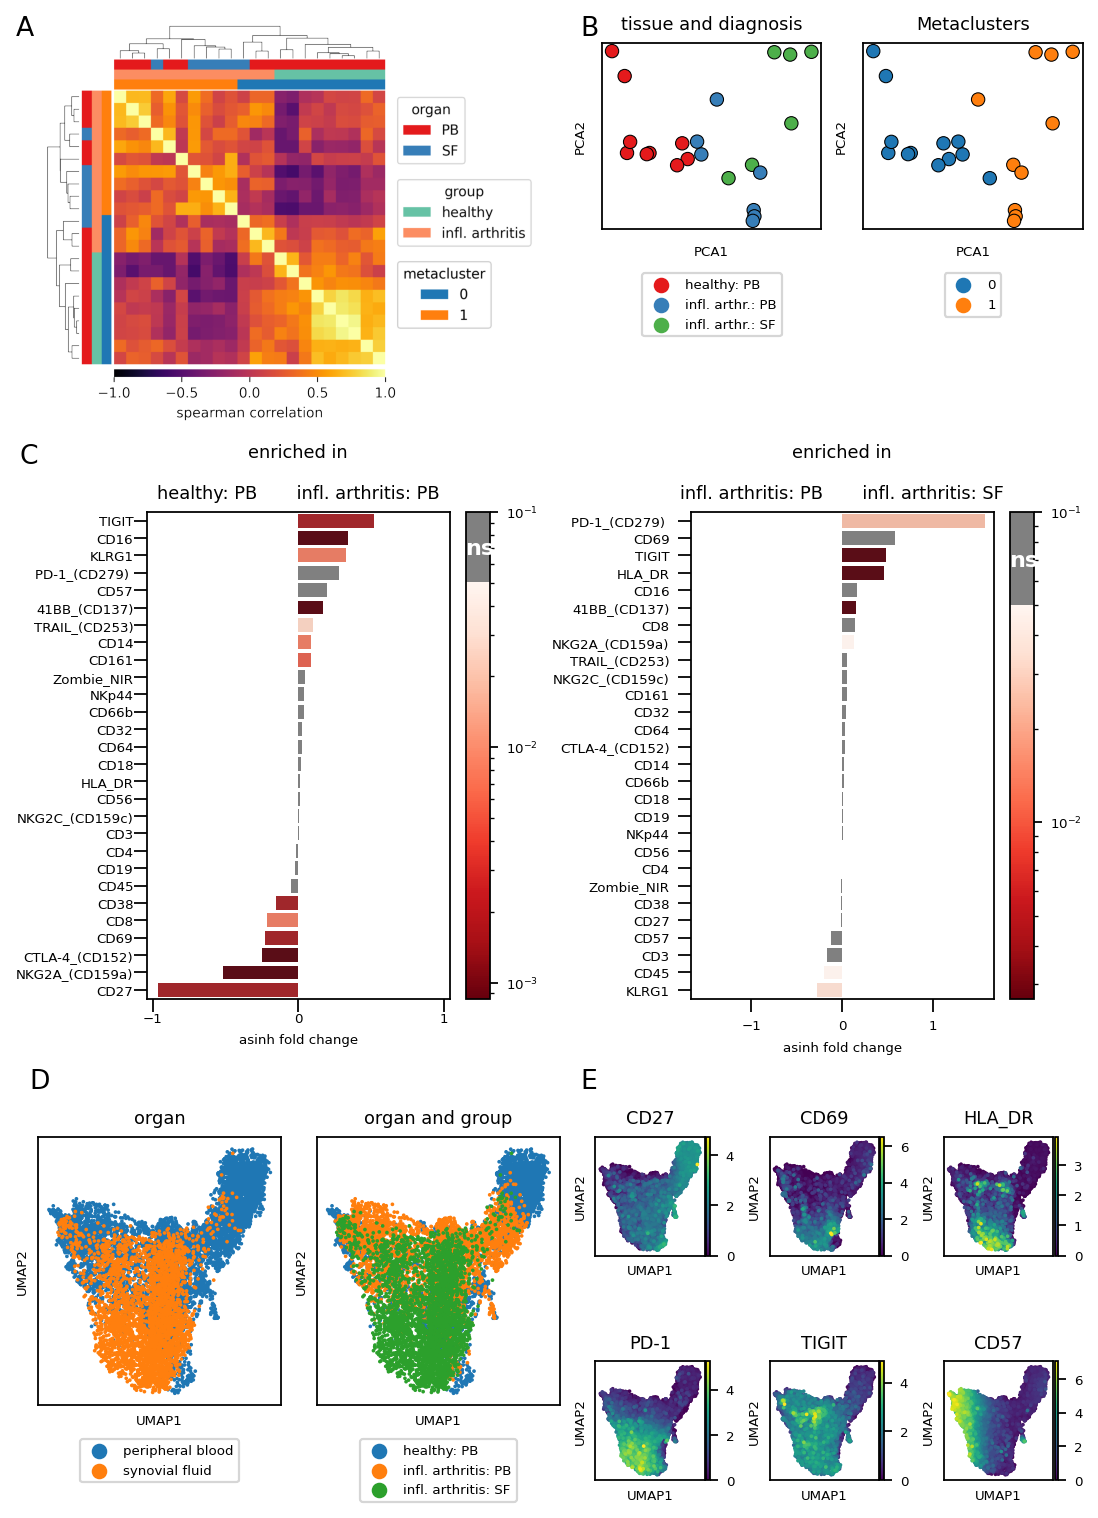

In [12]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

fig = plt.figure(layout = "constrained",
                 figsize = (cfg.FIGURE_WIDTH_FULL, cfg.FIGURE_HEIGHT_FULL))
gs = GridSpec(ncols = 8,
              nrows = 3,
              figure = fig,
              height_ratios = [1,1.5, 1.05])
a_coords = gs[0,:4]
b_coords = gs[0,4:]
c_coords = gs[1,:]
d_coords = gs[2,:4]
e_coords = gs[2,4:]

fig_a = fig.add_subplot(a_coords)
fig_b = fig.add_subplot(b_coords)
fig_c = fig.add_subplot(c_coords)
fig_d = fig.add_subplot(d_coords)
fig_e = fig.add_subplot(e_coords)

sns.reset_defaults()
generate_subfigure_a(fig, fig_a, a_coords, "A")
generate_subfigure_b(fig, fig_b, b_coords, "B")
generate_subfigure_c(fig, fig_c, c_coords, "C")
generate_subfigure_d(fig, fig_d, d_coords, "D")
generate_subfigure_e(fig, fig_e, e_coords, "E")

plt.savefig(os.path.join(cfg.figure_output, "Figure4.pdf"), dpi = 300, bbox_inches = "tight")
plt.show()